imports

In [1]:
import torch
import os
import numpy as np
from tqdm import tqdm

import pandas as pd

from myhelpers import cifar_dataLoader

from HGNN.train.configParser import ConfigParser
from HGNN.train import CNN, dataLoader
from myhelpers.memory import get_cuda_memory

experimetnsFileName = "experiments.csv"

parameters

In [2]:
experimentsPath="/raid/elhamod/CIFAR_HGNN/experiments/"
dataPath="/raid/elhamod/"
experimentName="CIFAR_phylogeny_HGNN_lambdaExperiment"
trial_hash="43685e27da0ec8febf221e2679a93761a6a51db65bc4571838fd4404"

cuda=1
batch_size = 128
num_workers = 8

cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)
    
torch.multiprocessing.set_start_method('spawn')

using cuda 1


Get dataset

In [4]:
# Get experiment parameters
experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
if os.path.exists(experimentsFileNameAndPath):
    experiments_df = pd.read_csv(experimentsFileNameAndPath)
    experiments_df = experiments_df.where(pd.notnull(experiments_df), None)
else:
    raise Exception("Experiment not " + trial_hash + " found!")
experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
experiment_params = experimentRecord.to_dict('records')[0]
print(experiment_params)

config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
experimentPathAndName = os.path.join(experimentsPath, experimentName)
if experiment_params['image_path'] == 'cifar-100-python':
    datasetManager = cifar_dataLoader.datasetManager(experimentPathAndName, dataPath)
else:
    datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)
datasetManager.updateParams(config_parser.fixPaths(experiment_params))
train_dataset, test_dataset = datasetManager.getDataset()
train_loader, validation_loader, test_loader = datasetManager.getLoaders()

dataset = test_dataset

{'experimentName': 'CIFAR_phylogeny_HGNN_lambdaExperiment', 'modelName': 'models/43685e27da0ec8febf221e2679a93761a6a51db65bc4571838fd4404', 'datasetName': 'datasplits/dd10c35154ee995db5de0276a21ca1a15a77964ee53811d98f089e89', 'experimentHash': '51df751b31fa4cb618a0ac0e36a75b9c587e691003ca6aa0b295f0c9', 'trialHash': '43685e27da0ec8febf221e2679a93761a6a51db65bc4571838fd4404', 'image_path': 'cifar-100-python', 'suffix': None, 'img_res': 32, 'augmented': False, 'batchSize': 128, 'learning_rate': 0.0003, 'numOfTrials': 5, 'fc_layers': 1, 'modelType': 'HGNN', 'lambda': 0.0, 'unsupervisedOnTest': None, 'tl_model': 'CIFAR', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.015, 'adaptive_alpha': 0.95, 'noSpeciesBackprop': False, 'phylogeny_loss': 'False', 'phylogeny_loss_epsilon': 0.03, 'tripletEnabled': None, 'tripletSamples': None, 'tripletSelector': None, 'tripletMargin': None, 'displayName': None, 'adaptive_alphalambda': None}
Creating dataset...
Loading dataset...


Get untrained model

In [5]:
architecture = {
    "fine": len(dataset.csv_processor.getFineList()),
    "coarse" : len(dataset.csv_processor.getCoarseList())
}
model = CNN.create_model(architecture, experiment_params, cuda)

# get the model and the parameters
modelName = experimentRecord.iloc[0]["modelName"]
trialName = os.path.join(experimentPathAndName, modelName)
_ = CNN.loadModel(model, trialName)
model.eval()

Model loaded into cpu!


CNN_Two_Nets(
  (network_coarse): CifarResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv

In [6]:
predProblist_, lbllist = CNN.getLoaderPredictionProbabilities(test_loader, model, experiment_params, device=cuda)

sort through predictions

In [7]:
def get_classification_df(predProblist_, lbllist, modelName, experimentPathAndName):

    df_misclassified = pd.DataFrame(columns=['file name', 'true label', 'probability of true label', 'predicted label'])
    df_correctlyclassified = pd.DataFrame(columns=['file name', 'true label', 'probability of true label', 'predicted label'])

    # get probability of correct prediction and true label
    
    _, predlist = torch.max(predProblist_, 1)
    lbllist = lbllist.reshape(lbllist.shape[0], -1)
    predProblist = predProblist_.gather(1, lbllist)
    predProblist = predProblist.reshape(1, -1)
    predProblist = predProblist[0]

    # sort through
    predProblist, indices = torch.sort(predProblist)
    predlist = predlist[indices]
    lbllist = lbllist[indices]

    for i, lbl in tqdm(enumerate(lbllist), total=len(lbllist)):
        prd = predlist[i]
        prdProb = predProblist[i]

        if torch.cuda.is_available():
            lbl = lbl.cpu()
            prd = prd.cpu()
            prdProb = prdProb.cpu()

        s = dataset[indices[i]]
        row = {'file name' : s['fileName'] , 
               'true label' : int(lbl.numpy()), 
               'probability of true label': float(prdProb.numpy()),
               'predicted label' : int(prd.numpy()),
              'original_index': int(indices[i])}

        if(lbl != prd):
            df_misclassified = df_misclassified.append(row, ignore_index=True)
        else:
            df_correctlyclassified = df_correctlyclassified.append(row, ignore_index=True)


    df_misclassified = df_misclassified.sort_values(by=[ 'true label', 'probability of true label'])
    df_correctlyclassified = df_correctlyclassified.sort_values(by=['true label', 'probability of true label'])
    
    df_misclassified.to_csv(os.path.join(experimentPathAndName, modelName, 'misclassified examples.csv'))
    df_correctlyclassified.to_csv(os.path.join(experimentPathAndName, modelName, 'correctly classified examples.csv'))
    
    return df_misclassified, df_correctlyclassified

In [8]:
df_misclassified, df_correctlyclassified = get_classification_df(predProblist_, lbllist, modelName, experimentPathAndName)

100%|██████████| 10000/10000 [00:48<00:00, 206.50it/s]


Display and save mispredicted

In [9]:
df_misclassified

,file name,true label,probability of true label,predicted label,original_index
201,b'pearmain_s_000136.png',0,0.005807,83,235.0
524,b'mcintosh_s_000330.png',0,0.011033,2,4676.0
583,b'northern_spy_s_000273.png',0,0.012222,2,4346.0
968,b'red_delicious_s_002149.png',0,0.020819,92,6872.0
1283,b'red_delicious_s_001498.png',0,0.029720,83,9849.0
...,...,...,...,...,...
2964,b'blood_fluke_s_000053.png',99,0.195160,61,2398.0
3040,b'worm_s_000954.png',99,0.231276,44,2625.0
3050,b'nematode_s_000074.png',99,0.240506,78,1340.0
3089,b'nematode_s_000023.png',99,0.278719,78,3479.0


Filename of correctly classified

In [10]:
df_correctlyclassified

,file name,true label,probability of true label,predicted label,original_index
46,b'macoun_s_001461.png',0,0.064464,0,5170.0
438,b'red_delicious_s_001531.png',0,0.140318,0,3752.0
575,b'red_delicious_s_000158.png',0,0.165409,0,3492.0
678,b'cortland_s_000133.png',0,0.181779,0,1014.0
689,b'red_delicious_s_002117.png',0,0.183430,0,9387.0
...,...,...,...,...,...
6413,b'nematode_s_001376.png',99,0.982430,99,9300.0
6416,b'roundworm_s_000508.png',99,0.982483,99,4717.0
6516,b'flatworm_s_000256.png',99,0.986724,99,9436.0
6728,b'ascaris_lumbricoides_s_000198.png',99,0.994847,99,3623.0


In [11]:
import matplotlib.pyplot as plt
import torchvision as tv

def imshow(img):
    img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()   # convert from tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()
    
def showExample(dataset, index, predictions):    
    prediction = predictions[index, :]
    entry =dataset[index]
    imshow(tv.utils.make_grid(entry['image']))
    fileName = entry['fileName']
    truth_fine = dataset.getFineList()[entry['fine']]
    truth_coarse = dataset.getCoarseList()[entry['coarse']]
    print('File name', fileName)
    print('Truth', truth_fine, truth_coarse)
    print('Sorted predictions')
    df = pd.DataFrame(columns=["Top", "fine label", "coarse label", "model's prob of fine label"])
    prediction_sorted, prediction_indices = torch.sort(prediction, descending=True)
    for i, pred in enumerate(prediction_sorted):
        pred_fine = dataset.getFineList()[prediction_indices[i].item()]
        pred_coarse = dataset.getCoarseFromFine(pred_fine)
        pred_prob = pred.item()
        df = df.append({
         "Top": i,
         "fine label":  pred_fine,
         "coarse label":  pred_coarse,
         "model's prob of fine label":  pred_prob,
        }, ignore_index=True)
    return df

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


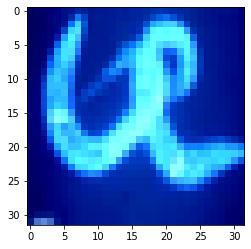

File name b'nematode_s_001376.png'
Truth worm b'non-insect_invertebrates'
Sorted predictions


,Top,fine label,coarse label,model's prob of fine label
0,0,worm,b'non-insect_invertebrates',0.982430
1,1,snake,b'reptiles',0.009724
2,2,shark,b'fish',0.000576
3,3,keyboard,b'household_electrical_devices',0.000402
4,4,mountain,b'large_natural_outdoor_scenes',0.000377
...,...,...,...,...
95,95,dinosaur,b'reptiles',0.000042
96,96,orange,b'fruit_and_vegetables',0.000042
97,97,otter,b'aquatic_mammals',0.000042
98,98,flatfish,b'fish',0.000042


In [12]:
original_index = 9300
showExample(dataset, original_index, predProblist_)

In [29]:
# given a dataset, a model, an activation name, and an input, find K the closest image in that space

def getClosestImageFromDataset(dataset, model, activation_layer, image, topk=2):   
    model = model.network_fine
    dist_func = torch.nn.MSELoss(reduction='none')
    hist_list = []
    
    f, axarr = plt.subplots(1,topk, squeeze=False)
    
    # get loader
    loader = torch.utils.data.DataLoader(dataset, pin_memory=True, batch_size=batch_size, num_workers=num_workers)
    
    if cuda:
        image = image.cuda()
    
    # get activation of image
    features = model(image)[activation_layer]
    distance = None
    
    # loop through loader
    for i, batch in tqdm(enumerate(loader), total=len(loader)):
        image2 = batch['image']
        if cuda:
            image2 = image2.cuda()
        features2 = model(image2)[activation_layer]
    
        # Calculate distance for each pair.
        temp = torch.sqrt(torch.sum(dist_func(torch.cat(features2.shape[0]*[features]), features2).detach(), 1))
        distance =  temp if distance is None else torch.cat([distance, temp]) 
    
    if cuda:
        distance = distance.cpu()
    hist_list = list(distance.numpy()) 
    distance = distance.reshape(-1)
    inv_distance = 1/distance
    
    _, topk_distances_indices = inv_distance.topk(topk, 0, True, True)
    
    # print information about best one
    for k, index in enumerate(topk_distances_indices):
        batch = dataset[index]
        img = batch['image'] / 2 + 0.5   # unnormalize
        npimg = img.numpy()   # convert from tensor
        axarr[0,k].imshow(np.transpose(npimg, (1, 2, 0)))
        fileName = batch['fileName']
        fineName = dataset.getFineList()[batch['fine']]
        coarseName = dataset.getCoarseList()[batch['coarse']]
        d = distance[index].item()

        string = fileName.decode("utf-8") + "\n"
        string = string + fineName + "\n"
        string = string + coarseName.decode("utf-8") + "\n"
        string = string +"d = " + str(round(d, 2))
        axarr[0, k].set_title(string)

    plt.figure()
    plt.hist(hist_list, 20)
    plt.title("Histogram of distances")
    

{'fine': tensor([[ 0.0000,  0.0981,  0.0000,  0.0000,  0.0000,  0.9374,  0.0000,  0.0000,
          0.0000,  0.1456,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0202,  0.0000,  0.4035,  0.0000,  0.0000,  0.0000,  0.5687,  0.0000,
          0.0000,  0.0000,  0.5396,  0.0000,  0.0000,  0.0000,  0.0000,  0.2366,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0356,  2.2599,
          1.7168,  0.0000,  0.0000,  0.9666,  0.4979,  0.1904,  0.0000,  0.0000,
          0.0000,  2.1943,  0.0000,  1.6877,  0.4377,  0.0000,  1.2708,  0.0000,
          0.0000,  1.0975,  0.5705,  1.1579,  0.0000,  1.8082,  0.0000,  0.0000,
          0.6693,  1.3245,  0.0000,  1.7056,  0.3177,  1.0621,  0.7761,  0.0000,
          0.0000,  2.6189,  0.0000,  2.1785,  0.6137,  0.0251,  5.4455,  0.0000,
          0.1488,  0.0000,  1.3230,  0.0000,  1.4696,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.3610,  0.0000,  0.0000,  0.0000,
          0.0436,  

IndexError: too many indices for tensor of dimension 2

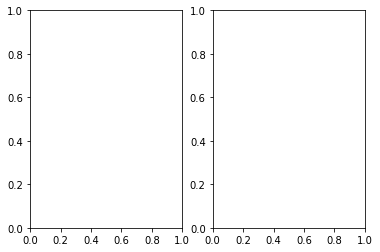

In [30]:
# getClosestImageFromDataset(dataset, model, 'fine', dataset[original_index]['image'].unsqueeze(0))
getClosestImageFromDataset(dataset, model, 'fine', dataset[original_index]['image'].unsqueeze(0))